In [1]:
!pip install -q utils
!pip install -q mxnet
!pip install --upgrade ta

     |████████████████████████████████| 68.7MB 55kB/s 
  Created wheel for ta: filename=ta-0.5.17-cp36-none-any.whl size=23658 sha256=bdaaca3d25de557bd81fa391e9c17f02e0caf596101e7ef32bb8196c610d6701
  Stored in directory: /root/.cache/pip/wheels/35/cf/3d/f2311e48805ddb99143597f0b38df4196fcbbfdf0c61eae3e8
Successfully built ta


In [0]:
from utils import *

import time
import numpy as np

import ta

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn import decomposition

import xgboost as xgb
from xgboost import plot_importance

pca = decomposition.PCA()

In [0]:
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')
    

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv \
    -O /tmp/gs.csv

--2020-03-31 01:11:24--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231285 (226K) [text/plain]
Saving to: ‘/tmp/gs.csv’

/tmp/gs.csv         100%[===================>] 225.86K  --.-KB/s    in 0.05s   

2020-03-31 01:11:25 (4.49 MB/s) - ‘/tmp/gs.csv’ saved [231285/231285]



In [5]:
dataset_ex_df = pd.read_csv('/tmp/gs.csv', header=0, parse_dates=[0], date_parser=parser)
dataset_ex_df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-05-04,67.665,68.780,62.329,62.659,24472946,0
1,1999-05-05,62.213,62.213,58.991,61.547,8295140,0
2,1999-05-06,60.542,61.773,59.712,60.488,3185852,0
3,1999-05-07,60.488,66.671,59.429,65.998,5331091,0
4,1999-05-10,65.331,65.441,62.549,62.941,2839054,0


In [6]:
# Add all ta features filling nans values
dataset_ex_df = ta.add_all_ta_features(dataset_ex_df, "Open", "High", "Low", "Close", "Volume", fillna=True)
for_pca=pd.DataFrame()
for_pca[['Date','Close']]=dataset_ex_df[['Date','Close']]
print(for_pca.head())
dataset_ex_df.drop(['Date','Open','High','Low','Volume','OpenInt'],axis=1,inplace=True)

        Date   Close
0 1999-05-04  62.659
1 1999-05-05  61.547
2 1999-05-06  60.488
3 1999-05-07  65.998
4 1999-05-10  62.941


In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.67)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [9]:
#Statistical Checks
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

#Standardization
sample_data=dataset_ex_df.fillna(0)
pd.set_option("display.max_rows",None)
standardized_data = StandardScaler().fit_transform(sample_data)
standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
# for_pca['Close']=standardized_data['Close'].to_list()



#MultiCollearity Check
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(standardized_data.values, i) for i in range(standardized_data.shape[1])]
vif["features"] = standardized_data.columns
print(vif.round(1))

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(standardized_data)

#Regression Table
est=sm.OLS(y_train_FI, X_train_FI)
est = est.fit()
est.summary()

    VIF Factor                   features
0          inf                      Close
1         11.1                 volume_adi
2          8.0                 volume_obv
3          3.7                 volume_cmf
4          3.6                  volume_fi
5          5.6               momentum_mfi
6          1.9                  volume_em
7          2.8              volume_sma_em
8          2.5                 volume_vpt
9          4.2                 volume_nvi
10        38.4             volatility_atr
11         inf             volatility_bbm
12         inf             volatility_bbh
13         inf             volatility_bbl
14        27.5             volatility_bbw
15       107.7             volatility_bbp
16         2.1            volatility_bbhi
17         2.1            volatility_bbli
18         inf             volatility_kcc
19         inf             volatility_kch
20         inf             volatility_kcl
21        39.7             volatility_kcw
22        37.7             volatil

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.022e+31
Date:                Tue, 31 Mar 2020   Prob (F-statistic):                        0.00
Time:                        01:13:03   Log-Likelihood:                      1.0122e+05
No. Observations:                3122   AIC:                                 -2.023e+05
Df Residuals:                    3058   BIC:                                 -2.019e+05
Df Model:                          64                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
volume_adi                -2.652e-16   1.15e-16     -2.302      0.021   -4.91e-16   -3.94e-17
volume_obv                 1.015e-15   1.25e-16      8.090      0.000    7.69e-16    1.26e-15
volume_cmf                -1.522e-16   7.22e-17     -2.109      0.035   -2.94e-16   -1.07e-17
volume_fi                 -3.415e-16   5.93e-17     -5.758      0.000   -4.58e-16   -2.25e-16
momentum_mfi               6.072e-17   8.67e-17      0.701      0.484   -1.09e-16    2.31e-16
volume_em                  -6.89e-17   4.38e-17     -1.574      0.115   -1.55e-16    1.69e-17
volume_sma_em             -2.253e-16   5.49e-17     -4.104      0.000   -3.33e-16   -1.18e-16
volume_vpt                -7.042e-17   4.92e-17     -1.431      0.153   -1.67e-16    2.61e-17
volume_nvi                 2.506e-15   1.37e-16     18.336      0.000    2.24e-15    2.77e-15
volatility_atr            -4.755e-16   2.11e-16     -2.250      0.025    -8.9e-16   -6.11e-17
volatility_bbm             5.057e-16   2.65e-15      0.191      0.848   -4.68e-15    5.69e-15
volatility_bbh             7.078e-16   2.95e-15      0.240      0.811   -5.08e-15     6.5e-15
volatility_bbl              2.88e-16   2.94e-15      0.098      0.922   -5.48e-15    6.05e-15
volatility_bbw             1.988e-16   1.89e-16      1.054      0.292   -1.71e-16    5.69e-16
volatility_bbp            -2.446e-16   3.74e-16     -0.654      0.513   -9.78e-16    4.89e-16
volatility_bbhi            9.953e-17    5.4e-17      1.844      0.065   -6.32e-18    2.05e-16
volatility_bbli           -1.001e-16   5.29e-17     -1.893      0.058   -2.04e-16     3.6e-18
volatility_kcc            -3.223e-15   2.57e-15     -1.253      0.210   -8.27e-15    1.82e-15
volatility_kch              4.26e-15   4.71e-15      0.905      0.365   -4.97e-15    1.35e-14
volatility_kcl            -3.511e-15   4.45e-15     -0.790      0.430   -1.22e-14    5.21e-15
volatility_kcw            -1.592e-16   2.23e-16     -0.713      0.476   -5.97e-16    2.78e-16
volatility_kcp            -2.145e-16   2.32e-16     -0.923      0.356    -6.7e-16    2.41e-16
volatility_kchi            3.356e-17   6.93e-17      0.484      0.629   -1.02e-16     1.7e-16
volatility_kcli           -2.721e-16   6.42e-17     -4.239      0.000   -3.98e-16   -1.46e-16
volatility_dcl            -6.106e-16   1.49e-15     -0.409      0.683   -3.54e-15    2.32e-15
volatility_dch              -3.4e-16   1.73e-15     -0.197      0.844   -3.73e-15    3.05e-15
volatility_dchi           -1.433e-16   6.05e-17     -2.371      0.018   -2.62e-16   -2.48e-17
volatility_dcli           -1.525e-16   5.68e-17     -2.685      0.007   -2.64e-16   -4.12e-17
trend_macd                 1.547e-15   3.67e-16      4.216      0.000 

In [0]:
params={'colsample_bytree': 0.5,
 'eval_metric': 'rmse',
 'gamma': 5,
 'learning_rate': 0.005006883383023541,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 193,
 'optimizer': 'MomentumSGD',
 'scale_pos_weight': 41,
 'objective' :'reg:linear',
 'subsample': 0.9}

[01:13:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.478328


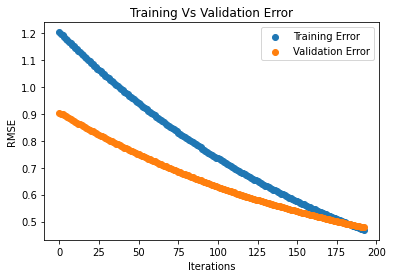

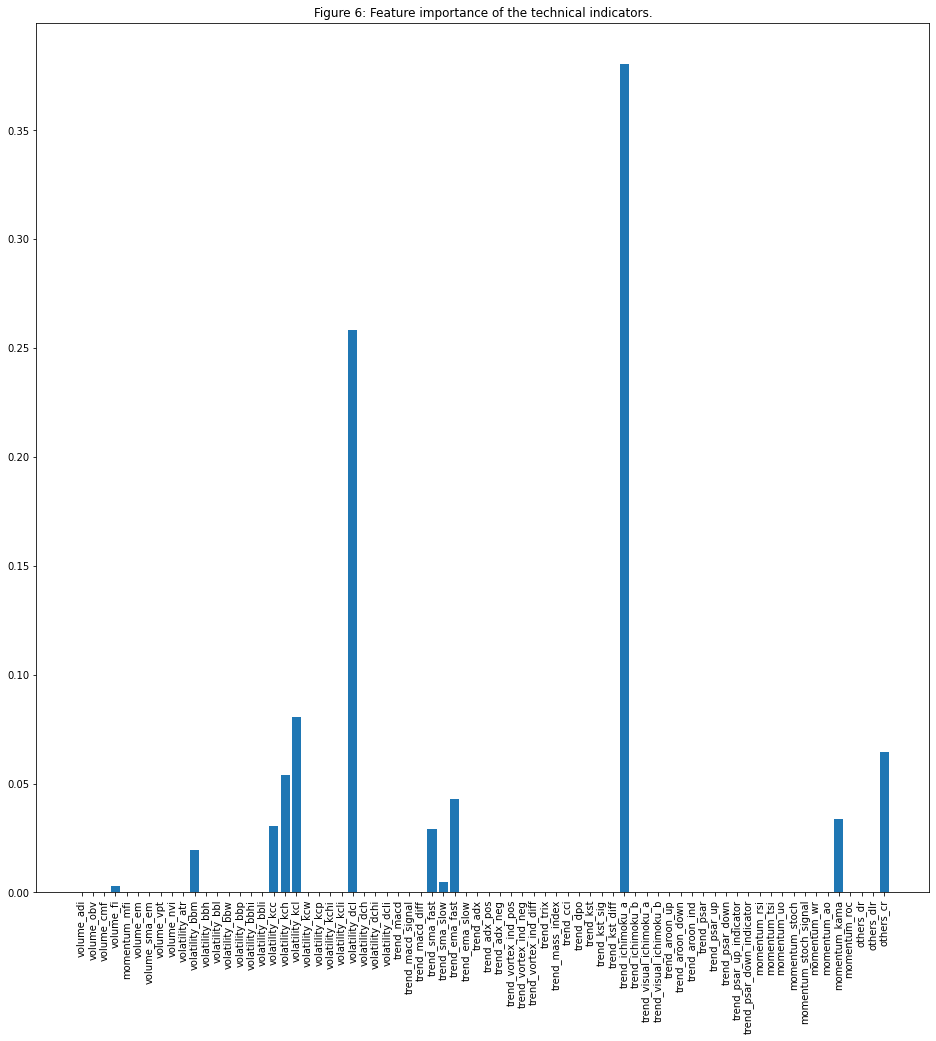

In [11]:
#regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
regressor = xgb.XGBRegressor(**params)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
preds = regressor.predict(X_test_FI)
rmse = np.sqrt(mean_squared_error(y_test_FI, preds))
print("RMSE: %f" % (rmse))
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

#validation graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#Bar graph
fig = plt.figure(figsize=(16,16))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

[01:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:13:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
74    0.834932
Name: test-rmse-mean, dtype: float64


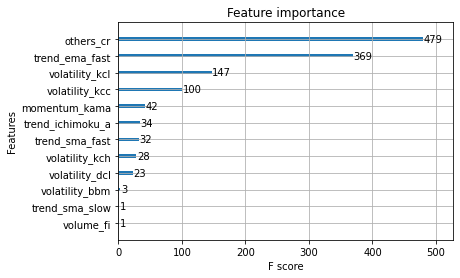

In [12]:
#Using K-Fold Cross-Validation
data_dmatrix = xgb.DMatrix(data=X_train_FI,label=y_train_FI)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=75,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

#Plot_Features
xgb.plot_importance(regressor)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


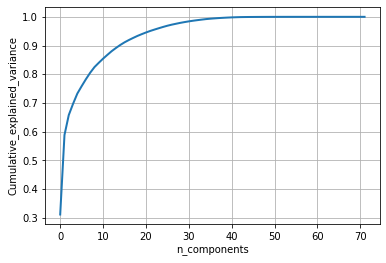

          0         1         2   ...        11         12         13
0 -11.106714  6.984356  6.400874  ...  1.332688  13.698511  39.346390
1  -9.833953  4.985088  2.125868  ...  0.017688  -1.102502  -6.176809
2  -9.376452  4.501222  3.089971  ...  3.826810   1.116745  -6.825182
3  -7.754517 -0.423525  7.481900  ...  0.394168   0.936463  -6.814380
4  -8.344719  1.630778  3.969893  ... -0.053775   0.164082  -5.867006

[5 rows x 14 columns]
shape of pca_reduced.shape =  (4661, 14)


In [13]:
#PCA for dimensionality Reduction
standardized_data.drop(['Close'],axis=1,inplace=True)
pca.n_components = standardized_data.shape[1]
pca_data = pca.fit_transform(standardized_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# #Reduced Dimension
pca.n_components = 14
pca_data = pca.fit_transform(standardized_data)
pca_df = pd.DataFrame(data=pca_data)
print(pca_df.head())
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)


In [14]:
pca_final=pca_df.copy()
pca_final['Close']=for_pca['Close']
pca_final.index=for_pca['Date']
print(pca_final.head())
pca_final.to_csv('/tmp/pca_final.csv')



                    0         1         2  ...         12         13   Close
Date                                       ...                              
1999-05-04 -11.106714  6.984356  6.400874  ...  13.698511  39.346390  62.659
1999-05-05  -9.833953  4.985088  2.125868  ...  -1.102502  -6.176809  61.547
1999-05-06  -9.376452  4.501222  3.089971  ...   1.116745  -6.825182  60.488
1999-05-07  -7.754517 -0.423525  7.481900  ...   0.936463  -6.814380  65.998
1999-05-10  -8.344719  1.630778  3.969893  ...   0.164082  -5.867006  62.941

[5 rows x 15 columns]
